# Visualization Demo

This is a notebook to demonsrate how to visualize the results of BackdoorBench by
* T-SNE
* Shapley Value
* Grad Cam

## Step 0: Generate Results File (optional)

In this notebook, we visualization the result of Badnet Attack on Tiny imagenet with PreactResnet18 and poison ratio 5%. 
We assume that the results are stored in **'../record/tiny_preactresnet18_badnet_0_05'** which can be generated using the following command.

In [1]:
! python -u ../attack/badnets_attack.py --yaml_path ../config/attack/badnet/tiny.yaml  --model preactresnet18 --pratio  0.05 --save_folder_name tiny_preactresnet18_badnet_0_05   --dataset tiny

python: can't open file '/workspace/weishaokui/bdzoo2/visualization/../attack/badnets_attack.py': [Errno 2] No such file or directory


## Step 1: Load results

In [1]:
import sys, os
import yaml
import shap
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms

sys.path.append("../")
sys.path.append(os.getcwd())
from visual_utils import *
from utils.aggregate_block.dataset_and_transform_generate import (
    get_transform,
    get_dataset_denormalization,
)
from utils.aggregate_block.model_trainer_generate import generate_cls_model
from utils.bd_dataset import prepro_cls_DatasetBD
from utils.save_load_attack import load_attack_result
from pytorch_grad_cam import (
    GradCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.image import show_cam_on_image
from utils.aggregate_block.fix_random import fix_random
### 1. basic setting: args
def get_args():
    #set the basic parameter
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--device', type=str, help='cuda, cpu')
    parser.add_argument('--yaml_path', type=str, default="../config/visualization/default.yaml", help='the path of yaml')
    parser.add_argument('--seed', type=str, help='random seed')
    parser.add_argument('--model', type=str, help='preactresnet18')

    # data parameters
    parser.add_argument("--dataset_path", type=str)
    parser.add_argument('--dataset', type=str, help='mnist, cifar10, cifar100, gtsrb, celeba, tiny') 
    parser.add_argument("--num_classes", type=int)
    parser.add_argument("--input_height", type=int)
    parser.add_argument("--input_width", type=int)
    parser.add_argument("--input_channel", type=int)
    parser.add_argument('--batch_size', type=int)
    parser.add_argument('--n_sub', default = 5000, type=int)
    parser.add_argument('--c_sub', default = 10, type=int)
    parser.add_argument("--num_workers", default=2, type=float)
    parser.add_argument('--class_names', type=list, help='names for each class') 

    # BD parameters
    parser.add_argument('--pratio', type=float)
    parser.add_argument('--attack_target', type=int)
    parser.add_argument('--index', type=str, help='index of clean data')

    # results parameters
    parser.add_argument('--result_file_attack', type=str, help='the location of attack result')
    parser.add_argument('--result_file_defense', type=str, help='the location of defense result')
    parser.add_argument('--checkpoint_load', type=str)
    parser.add_argument('--checkpoint_save', type=str)

    arg = parser.parse_args([])
    return arg
args = get_args()
with open(args.yaml_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({k: v for k, v in args.__dict__.items() if v is not None})
args.__dict__ = config
args.result_file_attack = "cifar10_preactresnet18_wanet_0_1"
args.result_file_defense =  "cifar10_preactresnet18_wanet_0_1/ft"
args.dataset = "cifar10"
args.pratio = 0.1
args = preprocess_args(args)
fix_random(int(args.random_seed))

save_path_attack = "../record_2/" + args.result_file_attack
if args.result_file_defense!='None':
    save_path_defense = "../record_2/" + args.result_file_defense

# Load data
result_attack = load_attack_result(save_path_attack + "/attack_result.pt")
x = result_attack["clean_test"]["x"]
y = result_attack["clean_test"]["y"]
x_bd = result_attack["bd_test"]["x"]
y_bd = result_attack["bd_test"]["y"]
# original label of bd data
bd_clean_idx = np.where(y != args.attack_target)[0]
y_bd_clean = y[bd_clean_idx]
x_bd_clean = [x[i] for i in bd_clean_idx]
# Load model
model = generate_cls_model(args.model, args.num_classes)
model.load_state_dict(result_attack["model"])
model.to(args.device)

if args.result_file_defense!='None':
    result_defense = load_attack_result(save_path_defense + "/defense_result.pt")
    model_defense = generate_cls_model(args.model, args.num_classes)
    model_defense.load_state_dict(result_defense["model"])
    model_defense.to(args.device)


criterion = nn.CrossEntropyLoss()
tran = get_transform(
    args.dataset, *([args.input_height, args.input_width]), train=False
)

# subsample classes for visualization if necessary
if args.num_classes > args.c_sub:
    # subsample c_sub classes
    class_sub = 1 + np.random.choice(
        args.num_classes - 1, size=args.c_sub - 1, replace=False
    )
    class_sub = class_sub.tolist()
    class_sub.append(args.attack_target)
    x, y = sample_by_classes(x, y, class_sub)
    x_bd, y_bd = sample_by_classes(x_bd, y_bd_clean, class_sub)

Files already downloaded and verified
Files already downloaded and verified


resize: 100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 43407.48it/s]


In [2]:
n = len(x)
n_sub = args.n_sub
# subsample clean data
if n > n_sub:
    sub_bin = int(n / n_sub)
    sub_idx = np.argsort(y)[::sub_bin]
    y_sub = y[sub_idx]
    x_sub = [x[i] for i in sub_idx]
else:
    y_sub = y
    x_sub = x

# subsample poison data
n_sub_bd = int(len(x_sub) * args.pratio)
sub_bin_bd = int(n / n_sub_bd)
sub_idx_bd = np.argsort(y_bd)[::sub_bin_bd]
y_bd_sub = y_bd[sub_idx_bd]

y_bd_clean_sub = np.copy(y_bd_sub)
y_bd_sub[:] = args.num_classes

x_bd_sub = [x_bd[i] for i in sub_idx_bd]

x_v = x_sub + x_bd_sub
y_v = np.concatenate([y_sub, y_bd_sub])
y_v_clean = np.concatenate([y_sub, y_bd_clean_sub])

data_set = list(zip(x_v, y_v))

data_set_o = prepro_cls_DatasetBD(
    full_dataset_without_transform=data_set,
    poison_idx=np.zeros(
        len(data_set)
    ),  # no further poison steps for visualization data
    bd_image_pre_transform=None,
    bd_label_pre_transform=None,
    ori_image_transform_in_loading=tran,
    ori_label_transform_in_loading=None,
    add_details_in_preprocess=False,
)
data_loader = torch.utils.data.DataLoader(
    data_set_o, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)

for trans_t in data_loader.dataset.ori_image_transform_in_loading.transforms:
    if isinstance(trans_t, transforms.Normalize):
        denormalizer = get_dataset_denormalization(trans_t)


pre-process bd dataset: 100%|███████████████████████████████████████████████████████████████████| 5450/5450 [00:00<00:00, 37189.60it/s]


* Visualize some image

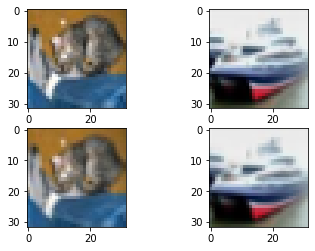

In [3]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_bd_clean[0])
axarr[0,1].imshow(x_bd_clean[1])
axarr[1,0].imshow(x_bd[0])
axarr[1,1].imshow(x_bd[1])


## Step 2: Visualization

### 2.1: T-SNE

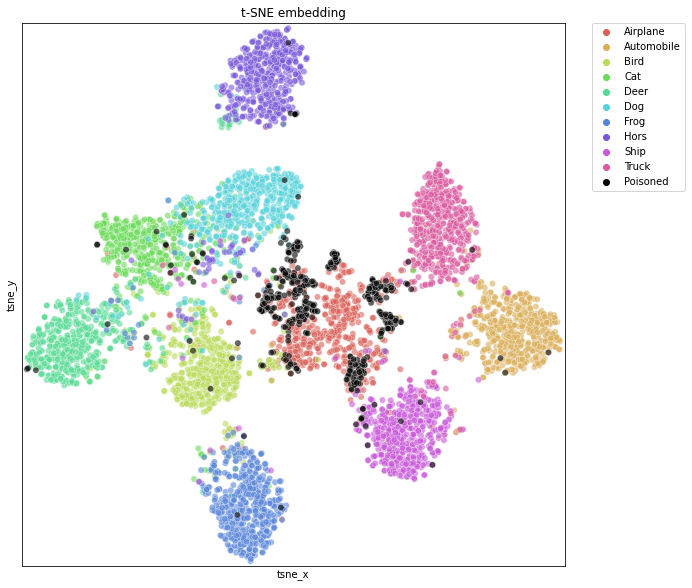

In [4]:
# Attack Plot
# Choose layer for feature extraction
if args.model == "preactresnet18":
    target_layer = model.layer4
if args.model == "vgg19":
    target_layer = model.features[-1]
if args.model == "resnet18":
    target_layer = model.layer4
if args.model == "densenet161":
    target_layer = model.features[-1]
if args.model == "mobilenet_v3_large":
    target_layer = model.features[-1]
if args.model == "efficientnet_b3":
    target_layer = model.features[-1]


features, labels = get_features(args, model, target_layer, data_loader)

sort_idx = np.argsort(labels)
features = features[sort_idx]
labels = labels[sort_idx]
classes = args.class_names + ["poisoned"]
label_class = [classes[i].capitalize() for i in labels]

# Plot T-SNE
custom_palette = sns.color_palette("hls", 10) + [
    (0.0, 0.0, 0.0)
]  # Black for poison samples
fig = tsne_fig(
    features,
    label_class,
    title="t-SNE embedding",
    xlabel="tsne_x",
    ylabel="tsne_y",
    custom_palette=custom_palette,
)
plt.savefig(save_path_attack + "/tsne.png")
plt.savefig(save_path_attack + "/tsne.pdf")

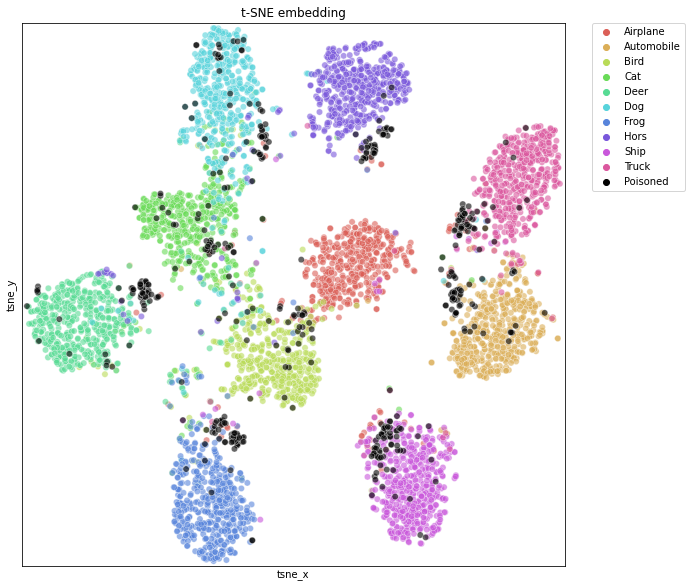

In [5]:
if args.result_file_defense!='None':
    # Defense Plot
    # Choose layer for feature extraction
    if args.model == "preactresnet18":
        target_layer = model_defense.layer4
    if args.model == "vgg19":
        target_layer = model_defense.features[-1]
    if args.model == "resnet18":
        target_layer = model_defense.layer4
    if args.model == "densenet161":
        target_layer = model_defense.features[-1]
    if args.model == "mobilenet_v3_large":
        target_layer = model_defense.features[-1]
    if args.model == "efficientnet_b3":
        target_layer = model_defense.features[-1]

    features_defense, labels_defense = get_features(args, model_defense, target_layer, data_loader)

    sort_idx = np.argsort(labels_defense)
    features_defense = features_defense[sort_idx]
    labels_defense = labels_defense[sort_idx]
    classes = args.class_names + ["poisoned"]
    label_class_defense = [classes[i].capitalize() for i in labels_defense]

    # Plot T-SNE
    custom_palette = sns.color_palette("hls", 10) + [
        (0.0, 0.0, 0.0)
    ]  # Black for poison samples
    fig = tsne_fig(
        features_defense,
        label_class_defense,
        title="t-SNE embedding",
        xlabel="tsne_x",
        ylabel="tsne_y",
        custom_palette=custom_palette,
    )
    plt.savefig(save_path_defense + "/tsne.png")
    plt.savefig(save_path_defense + "/tsne.pdf")

# Neuron Map

In [6]:
data_set_clean = list(zip(x_bd_clean, y_bd_clean))
data_set_bd = list(zip(x_bd, y_bd))

data_set_clean = prepro_cls_DatasetBD(
    full_dataset_without_transform=data_set_clean,
    poison_idx=np.zeros(
        len(data_set_clean)
    ),  # no further poison steps for visualization data
    bd_image_pre_transform=None,
    bd_label_pre_transform=None,
    ori_image_transform_in_loading=tran,
    ori_label_transform_in_loading=None,
    add_details_in_preprocess=False,
)

data_set_bd = prepro_cls_DatasetBD(
    full_dataset_without_transform=data_set_bd,
    poison_idx=np.zeros(
        len(data_set_bd)
    ),  # no further poison steps for visualization data
    bd_image_pre_transform=None,
    bd_label_pre_transform=None,
    ori_image_transform_in_loading=tran,
    ori_label_transform_in_loading=None,
    add_details_in_preprocess=False,
)


data_loader_clean = torch.utils.data.DataLoader(
    data_set_clean, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)
data_loader_bd = torch.utils.data.DataLoader(
    data_set_bd, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)


pre-process bd dataset: 100%|███████████████████████████████████████████████████████████████████| 9000/9000 [00:00<00:00, 47216.32it/s]


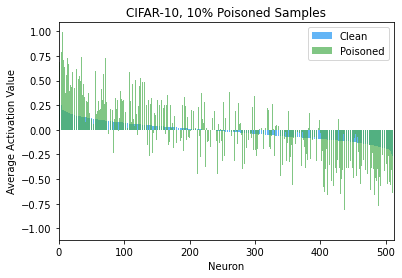

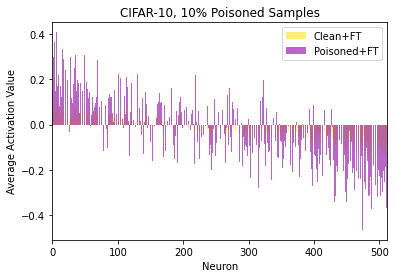

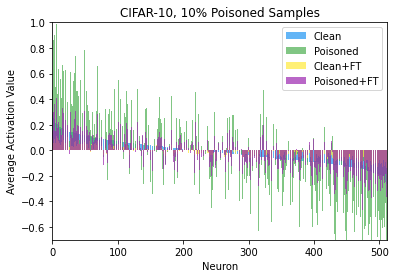

In [7]:
# Choose layer for feature extraction for Attack
if args.model == "preactresnet18":
    target_layer = model.avgpool
if args.model == "vgg19":
    target_layer = model.features[-1]
if args.model == "resnet18":
    target_layer = model.layer4
if args.model == "densenet161":
    target_layer = model.features[-1]
if args.model == "mobilenet_v3_large":
    target_layer = model.features[-1]
if args.model == "efficientnet_b3":
    target_layer = model.features[-1]

info_list = args.result_file_attack.split('_')

features_clean, labels_clean = get_features(args, model, target_layer, data_loader_clean)
features_clean_avg = np.mean(features_clean, axis =0)

features_bd, labels_bd = get_features(args, model, target_layer, data_loader_bd)
features_bd_avg = np.mean(features_bd, axis =0)

sort_bar = np.argsort(features_clean_avg)[::-1]

features_bd_avg=features_bd_avg[sort_bar]
features_clean_avg=features_clean_avg[sort_bar]

plt.figure()
plt.bar(np.arange(features_clean_avg.shape[0]),features_clean_avg, label="Clean", alpha =0.7, color = "#2196F3")
plt.bar(np.arange(features_bd_avg.shape[0]),features_bd_avg, label="Poisoned", alpha =0.7, color = "#4CAF50")
plt.xlabel("Neuron")
plt.ylabel("Average Activation Value")
plt.title(f"{get_dataname(args.dataset)}, {get_pratio(args.pratio)}% Poisoned Samples")
plt.xlim(0, features_clean_avg.shape[0])
plt.legend()
plt.savefig(save_path_attack+"/neuron.png")
plt.savefig(save_path_attack+"/neuron.pdf")

if args.result_file_defense!='None':

    # Choose layer for feature extraction for Defense
    if args.model == "preactresnet18":
        target_layer = model_defense.avgpool
    if args.model == "vgg19":
        target_layer = model_defense.features[-1]
    if args.model == "resnet18":
        target_layer = model_defense.layer4
    if args.model == "densenet161":
        target_layer = model_defense.features[-1]
    if args.model == "mobilenet_v3_large":
        target_layer = model_defense.features[-1]
    if args.model == "efficientnet_b3":
        target_layer = model_defense.features[-1]

    features_clean_defense, labels_clean_defense = get_features(args, model_defense, target_layer, data_loader_clean)
    features_clean_avg_defense = np.mean(features_clean_defense, axis =0)

    features_bd_defense, labels_bd_defense = get_features(args, model_defense, target_layer, data_loader_bd)
    features_bd_avg_defense = np.mean(features_bd_defense, axis =0)
    
    plt.figure()
    features_bd_avg_defense=features_bd_avg_defense[sort_bar]
    features_clean_avg_defense=features_clean_avg_defense[sort_bar]
    dn = get_defensename(args.result_file_defense.split('/')[-1])
    plt.bar(np.arange(features_clean_avg_defense.shape[0]),features_clean_avg_defense, label="Clean+"+dn, alpha =0.7, color = "#FFEB3B")
    plt.bar(np.arange(features_bd_avg_defense.shape[0]),features_bd_avg_defense, label="Poisoned+"+dn, alpha =0.7, color = "#9C27B0")    
    plt.xlabel("Neuron")
    plt.ylabel("Average Activation Value")
    plt.title(f"{get_dataname(args.dataset)}, {get_pratio(args.pratio)}% Poisoned Samples")
    plt.xlim(0, features_clean_avg_defense.shape[0])
    plt.legend()
    plt.savefig(save_path_defense+"/neuron.png")
    plt.savefig(save_path_defense+"/neuron.pdf")
    
    plt.figure()
    plt.bar(np.arange(features_clean_avg.shape[0]),features_clean_avg, label="Clean", alpha =0.7, color = "#2196F3")
    plt.bar(np.arange(features_bd_avg.shape[0]),features_bd_avg, label="Poisoned", alpha =0.7, color = "#4CAF50")
    plt.bar(np.arange(features_clean_avg_defense.shape[0]),features_clean_avg_defense, label="Clean+"+dn, alpha =0.7, color = "#FFEB3B")
    plt.bar(np.arange(features_bd_avg_defense.shape[0]),features_bd_avg_defense, label="Poisoned+"+dn, alpha =0.7, color = "#9C27B0")
    plt.xlabel("Neuron")
    plt.ylabel("Average Activation Value")
    plt.title(f"{get_dataname(args.dataset)}, {get_pratio(args.pratio)}% Poisoned Samples")
    plt.legend()
    plt.ylim(-0.7, 1.0)
    plt.xlim(0, features_clean_avg_defense.shape[0])
    plt.savefig(save_path_defense+"/neuron_compare.png")
    plt.savefig(save_path_defense+"/neuron_compare.pdf")

### 2.2 SHAP Value

# Gradient SHAP: Explain an Intermediate Layer 
Gradient SHAP is a gradient method to compute SHAP values, which are based on Shapley values proposed in cooperative game theory. Gradient SHAP adds Gaussian noise to each input sample multiple times, selects a random point along the path between baseline and input, and computes the gradient of outputs with respect to those selected random points. The final SHAP values represent the expected value of gradients.

The computed attributions approximate SHAP values under the assumptions that the input features are independent and that the explanation model is linear between the inputs and given baselines.

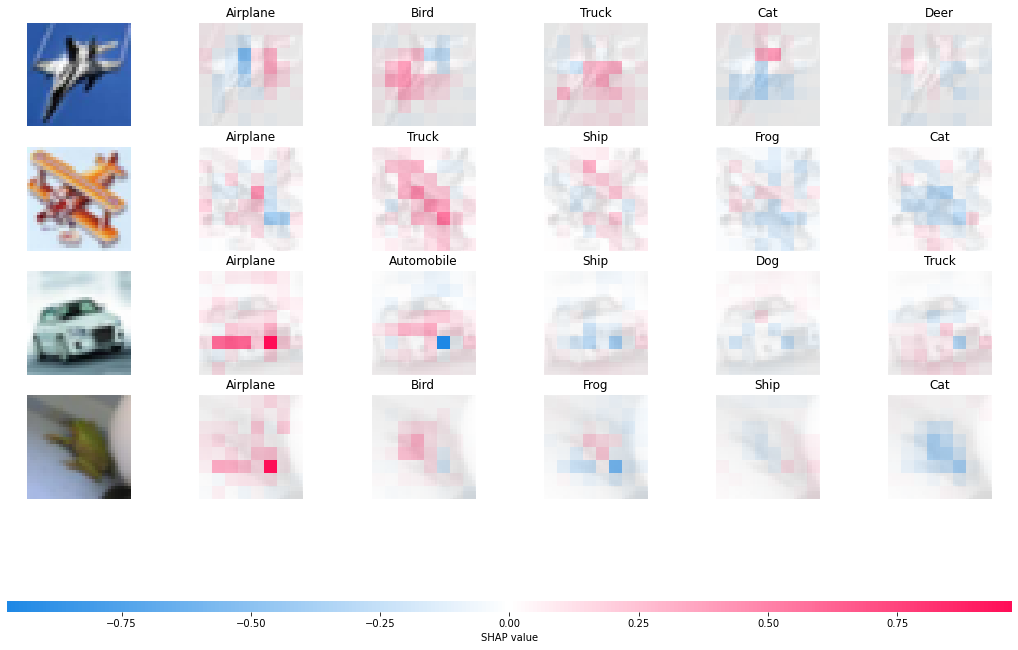

In [8]:
full_image = []
full_target = []
for batch_idx, (inputs, targets) in enumerate(data_loader):
    full_image.append(inputs)
    full_target.append(targets)
full_image_t = torch.cat(full_image, 0)
full_target_t = torch.cat(full_target, 0)

# choose data for visualization
n_v = 200
v_idx = np.random.choice(full_image_t.shape[0] - 4, n_v, replace=False)
background = full_image_t[2 + v_idx].to(args.device)
# background = full_image_t[-200:].to(args.device)

# 2 clean image + 2 poisoned image
test_images = torch.cat([full_image_t[:2], full_image_t[-2:]]).to(args.device)
# Get clean label for all test image
test_label = np.concatenate([y_v_clean[:2], y_v_clean[-2:]])

sfm = nn.Softmax(dim=1)


# Choose layer for SHAP
if args.model == "preactresnet18":
    target_layer = model.layer4
if args.model == "vgg19":
    target_layer = model.features
if args.model == "resnet18":
    target_layer = model.layer4
if args.model == "densenet161":
    target_layer = model.features
if args.model == "mobilenet_v3_large":
    target_layer = model.features
if args.model == "efficientnet_b3":
    target_layer = model.features

model.eval()

outputs = model(test_images)
pre_p, pre_label = torch.max(sfm(outputs), dim=1)

e = shap.GradientExplainer((model, target_layer), background, local_smoothing=0)
shap_values, indexes = e.shap_values(test_images, ranked_outputs=5)

# get the names for the classes
class_names = np.array(args.class_names).reshape([-1])
index_names = np.vectorize(lambda x: class_names[x].capitalize())(indexes.cpu())
# plot the explanations
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(
    np.swapaxes(denormalizer(test_images.cpu()).numpy(), 1, -1), 1, 2
)
test_numpy[test_numpy < 1e-12] = 1e-12  # for some numerical issue

shap.image_plot(shap_numpy, test_numpy, index_names, show=False)
plt.savefig(save_path_attack + "/shap.png")
plt.savefig(save_path_attack + "/shap.pdf")



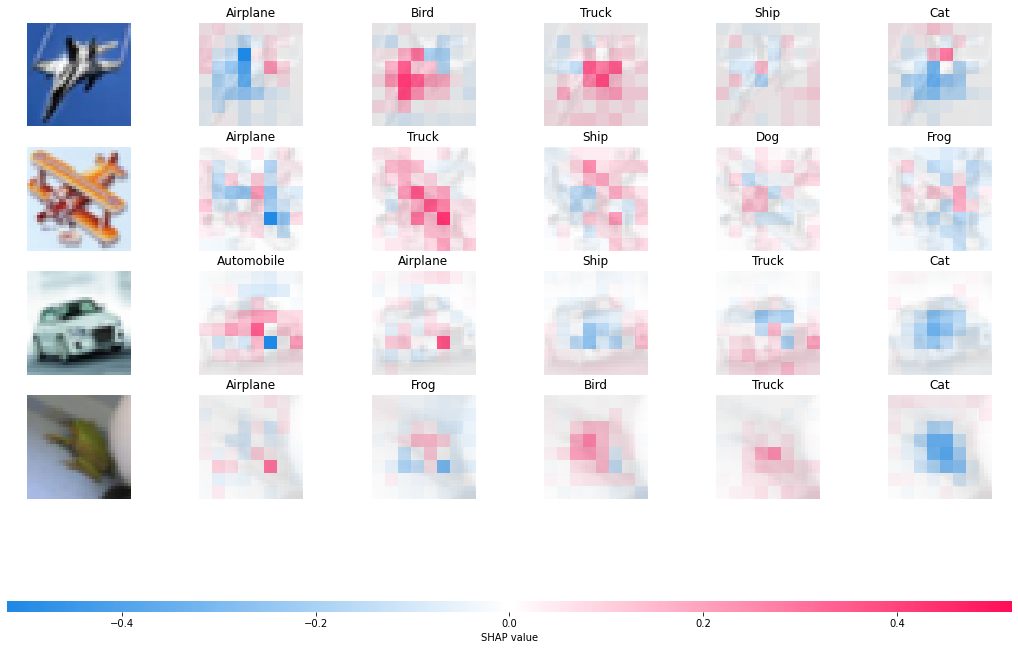

In [9]:
# Choose layer for SHAP for defense

if args.result_file_defense!='None':

    # Choose layer for SHAP
    if args.model == "preactresnet18":
        target_layer = model_defense.layer4
    if args.model == "vgg19":
        target_layer = model_defense.features
    if args.model == "resnet18":
        target_layer = model_defense.layer4
    if args.model == "densenet161":
        target_layer = model_defense.features
    if args.model == "mobilenet_v3_large":
        target_layer = model_defense.features
    if args.model == "efficientnet_b3":
        target_layer = model_defense.features

    model_defense.eval()

    outputs = model_defense(test_images)
    pre_p, pre_label = torch.max(sfm(outputs), dim=1)

    e = shap.GradientExplainer((model_defense, target_layer), background, local_smoothing=0)
    shap_values, indexes = e.shap_values(test_images, ranked_outputs=5)

    # get the names for the classes
    class_names = np.array(args.class_names).reshape([-1])
    index_names = np.vectorize(lambda x: class_names[x].capitalize())(indexes.cpu())
    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(
        np.swapaxes(denormalizer(test_images.cpu()).numpy(), 1, -1), 1, 2
    )
    test_numpy[test_numpy < 1e-12] = 1e-12  # for some numerical issue

    shap.image_plot(shap_numpy, test_numpy, index_names, show=False)
    plt.savefig(save_path_defense + "/shap.png")
    plt.savefig(save_path_defense + "/shap.pdf")
    



### 2.3: GradCam

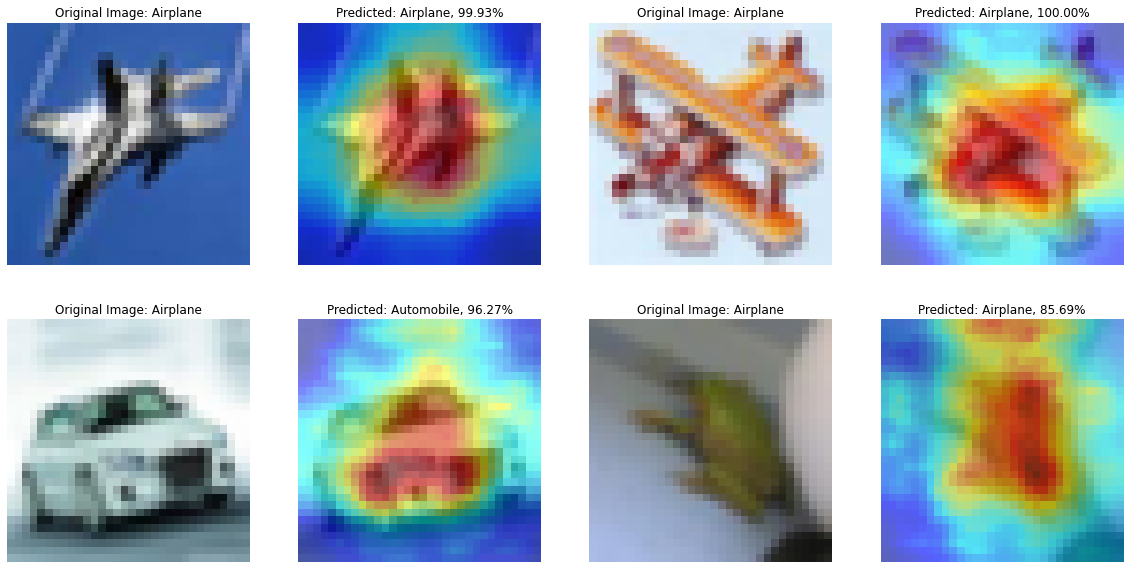

In [10]:
# choose layers for Grad Cam, refer to https://github.com/jacobgil/pytorch-grad-cam
if args.model == "preactresnet18":
    target_layers = [model.layer4[-1]]
if args.model == "vgg19":
    target_layers = [model.features[-1]]
if args.model == "resnet18":
    target_layers = [model.layer4[-1]]
if args.model == "densenet161":
    target_layers = [model.features[-1]]
if args.model == "mobilenet_v3_large":
    target_layers = [model.features[-1]]
if args.model == "efficientnet_b3":
    target_layers = [model.features[-1]]
    
input_tensor = test_images

cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)

targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_full = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam_full[0, :]
rgb_image = np.swapaxes(
    np.swapaxes(denormalizer(test_images[0]).cpu().numpy(), 0, 1), 1, 2
)
visual_cam = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for im in range(4):
    grayscale_cam = grayscale_cam_full[im, :]
    rgb_image = np.swapaxes(
        np.swapaxes(denormalizer(test_images[im]).cpu().numpy(), 0, 1), 1, 2
    )
    rgb_image[rgb_image < 1e-12] = 1e-12
    visual_cam = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
    axes[im // 2, im % 2 * 2].imshow(rgb_image)
    axes[im // 2, im % 2 * 2].axis("off")
    axes[im // 2, im % 2 * 2].set_title(
        "Original Image: %s" % (class_names[test_label[im]].capitalize())
    )
    axes[im // 2, im % 2 * 2 + 1].imshow(visual_cam)
    axes[im // 2, im % 2 * 2 + 1].axis("off")
    axes[im // 2, im % 2 * 2 + 1].set_title(
        "Predicted: %s, %.2f%%" % (class_names[pre_label[im]].capitalize(), pre_p[im] * 100)
    )
plt.savefig(save_path_attack + "/gracam.png")
plt.savefig(save_path_attack + "/gracam.pdf")


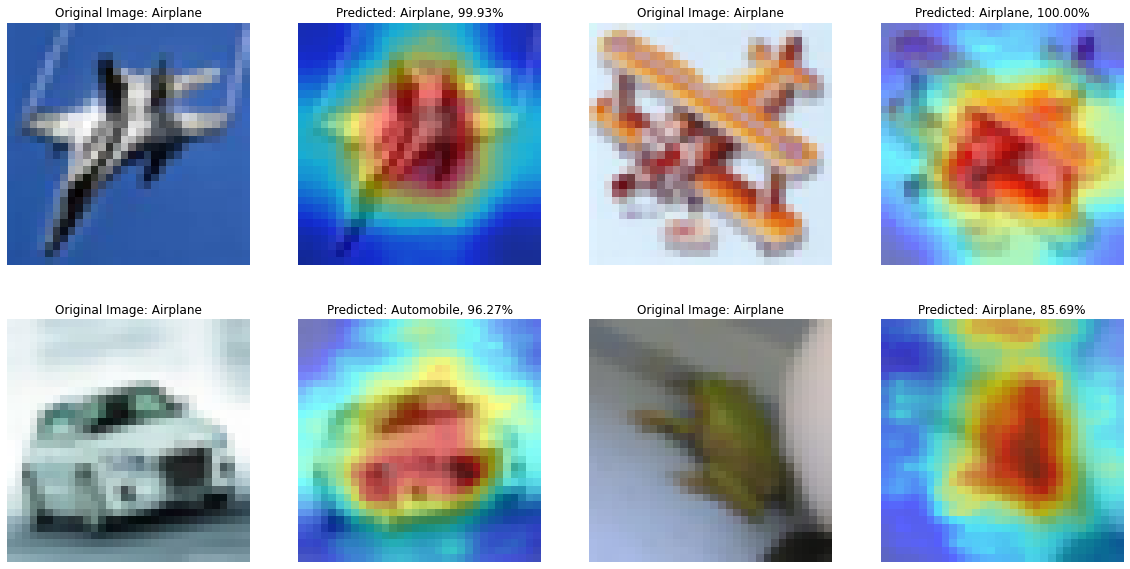

In [11]:

if args.result_file_defense!='None':
    # choose layers for Grad Cam, refer to https://github.com/jacobgil/pytorch-grad-cam
    if args.model == "preactresnet18":
        target_layers = [model_defense.layer4[-1]]
    if args.model == "vgg19":
        target_layers = [model_defense.features[-1]]
    if args.model == "resnet18":
        target_layers = [model_defense.layer4[-1]]
    if args.model == "densenet161":
        target_layers = [model_defense.features[-1]]
    if args.model == "mobilenet_v3_large":
        target_layers = [model_defense.features[-1]]
    if args.model == "efficientnet_b3":
        target_layers = [model_defense.features[-1]]

    input_tensor = test_images

    cam = FullGrad(model=model_defense, target_layers=target_layers, use_cuda=True)

    targets = None

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam_full = cam(input_tensor=input_tensor, targets=targets)

    grayscale_cam = grayscale_cam_full[0, :]
    rgb_image = np.swapaxes(
        np.swapaxes(denormalizer(test_images[0]).cpu().numpy(), 0, 1), 1, 2
    )
    visual_cam = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)


    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    for im in range(4):
        grayscale_cam = grayscale_cam_full[im, :]
        rgb_image = np.swapaxes(
            np.swapaxes(denormalizer(test_images[im]).cpu().numpy(), 0, 1), 1, 2
        )
        rgb_image[rgb_image < 1e-12] = 1e-12
        visual_cam = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
        axes[im // 2, im % 2 * 2].imshow(rgb_image)
        axes[im // 2, im % 2 * 2].axis("off")
        axes[im // 2, im % 2 * 2].set_title(
            "Original Image: %s" % (class_names[test_label[im]].capitalize())
        )
        axes[im // 2, im % 2 * 2 + 1].imshow(visual_cam)
        axes[im // 2, im % 2 * 2 + 1].axis("off")
        axes[im // 2, im % 2 * 2 + 1].set_title(
            "Predicted: %s, %.2f%%" % (class_names[pre_label[im]].capitalize(), pre_p[im] * 100)
        )
    plt.savefig(save_path_defense + "/gracam.png")
    plt.savefig(save_path_defense + "/gracam.pdf")
